# Analyzing Amazon review data

Amazon Fine Food reviews: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download

## Settings

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import norm
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans, MiniBatchKMeans

In [2]:
# Set a random seed
np.random.seed(8)

## Data wrangling

In [3]:
df = pd.read_csv("./data/reviews_amazon_fine_food.csv")

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## EDA

In [6]:
df['Text'][:20]

0     I have bought several of the Vitality canned d...
1     Product arrived labeled as Jumbo Salted Peanut...
2     This is a confection that has been around a fe...
3     If you are looking for the secret ingredient i...
4     Great taffy at a great price.  There was a wid...
5     I got a wild hair for taffy and ordered this f...
6     This saltwater taffy had great flavors and was...
7     This taffy is so good.  It is very soft and ch...
8     Right now I'm mostly just sprouting this so my...
9     This is a very healthy dog food. Good for thei...
10    I don't know if it's the cactus or the tequila...
11    One of my boys needed to lose some weight and ...
12    My cats have been happily eating Felidae Plati...
13    good flavor! these came securely packed... the...
14    The Strawberry Twizzlers are my guilty pleasur...
15    My daughter loves twizzlers and this shipment ...
16    I love eating them and they are good for watch...
17    I am very satisfied with my Twizzler purch

In [7]:
print('Number of unique users: ', df['UserId'].nunique())

Number of unique users:  256059


In [8]:
print('Number of reviewed products: ', df['ProductId'].nunique())

Number of reviewed products:  74258


In [9]:
print('Number of reviews: ', df.shape[0])

Number of reviews:  568454


In [10]:
print('On average, there are {} reviews per user'.format(df.shape[0]/df['UserId'].nunique()))

On average, there are 2.2200117941568154 reviews per user


In [11]:
print('On average, there are {} reviews per product'.format(df.shape[0]/df['ProductId'].nunique()))

On average, there are 7.655121333728353 reviews per product


In [12]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [13]:
df[['Score', 'HelpfulnessNumerator', 'HelpfulnessDenominator']].describe()

,Score,HelpfulnessNumerator,HelpfulnessDenominator
count,568454.000000,568454.000000,568454.00000
mean,4.183199,1.743817,2.22881
std,1.310436,7.636513,8.28974
min,1.000000,0.000000,0.00000
25%,4.000000,0.000000,0.00000
50%,5.000000,0.000000,1.00000
75%,5.000000,2.000000,2.00000
max,5.000000,866.000000,923.00000


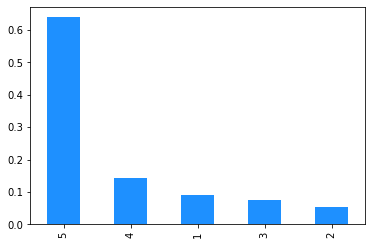

In [14]:
df['Score'].value_counts(normalize=True).plot.bar(color='dodgerblue');

In [15]:
df['Summary'].value_counts()[:20]

Delicious!       2462
Delicious        2316
Yummy!           1594
Yummy            1268
Great product    1091
Yum!             1081
Excellent         985
Great Product     910
Love it!          910
Great             749
Great!            748
Tasty             645
Yum               618
Disappointed      587
Excellent!        573
Great Coffee      558
Awesome!          550
Awesome           546
Good stuff        515
yummy             512
Name: Summary, dtype: int64

In [16]:
df['Text'][10]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

In [17]:
df['Text'][200]

"Even with small containers, they don't fill them up.  These little tins are less than half filled and at the price charged it seems a rip-off. Is there some exotic ingredient as costly as gold contained in those tiny squares?  Or how about the cereal ploy, they were filled at the factory but settled in transport.<br />Can manufacturers be honest in their dealings?"

In [18]:
df['Text'][18000]

"This stuff is really good added to oatmeal or greek yogurt.  As for a PB sandwich?  Not as sure.  I've mixed it with jelly, and it's pretty good, but I missed the texture contrast that you get with real PB.  I mitigate this by adding a very thin layer (I have a problem with putting WAY too much PB on) of real PB to my bread and then supplementing with the powdered stuff.  It works better that way, I think, and I don't get all the calories from using all regular PB.  I probably wouldn't buy this from amazon again because of the price, but I'm glad I tried it, and if it's on sale at whole foods or something I'd buy it.<br /><br />Oh, be careful when you're opening the jar for the first time...no sudden movements or you'll be covered in PB powder, and at this price, every grain is precious!"

In [19]:
df['Text'][345907]

"Warning -- this product contains nutrisweet, which I and may others are allergic to -- they don't say it on the amazon website so be careful!!!"

In [20]:
df['Text'][24]

"I have lived out of the US for over 7 yrs now, and I so miss my Twizzlers!!  When I go back to visit or someone visits me, I always stock up.  All I can say is YUM!<br />Sell these in Mexico and you will have a faithful buyer, more often than I'm able to buy them right now."

In [21]:
df['Text'][200783]

"We're staying at Stanford's Children's Hospital with my son, and I'm sure I don't have to elaborate how 'pleasant' hospital cafeteria food can be, even at a 'great' cafeteria (as hospital cafeteria's go, Stanford's is actually very good. But it is still cafeteria food). On weekends the Children's side cafeteria closes down so you have to go over to the main hospital's cafeteria for dinner. Grabbed a turkey sandwich and was looking for some chips or something crunchy, and I saw these. I'm a big coconut fan so I figured I couldn't go wrong, and it's healthier than potato chips so I'm game. I made the mistake of trying a bite of them before I had my sandwich, I didn't want to put the bag down! Holy smokes, seriously the best 'chip substitute' I've ever had, and if they weren't so expensive I'd switch over from potato chips completely!! Perfect combination of salty/sweet, loads of coconut flavor (I've had some where it's really subtle and mild, this definitely is not), great size strips (

In [22]:
df[df['Text'].str.contains('<br />')].shape

(142924, 10)

142,924 rows contain `<br />` characters.

Let us check other characters related to HTML syntax

In [23]:
df[df['Text'].str.contains('<')]['Text']

10        I don't know if it's the cactus or the tequila...
18        Twizzlers, Strawberry my childhood favorite ca...
21        I bought these for my husband who is currently...
24        I have lived out of the US for over 7 yrs now,...
25        Product received is as advertised.<br /><br />...
                                ...                        
568430    This product is a bit pricey for the amt. rece...
568433    I just bought this soup today at my local groc...
568439    We need this for a recipe my wife is intereste...
568446    I had ordered some of these a few months back ...
568447    Hoping there is no MSG in this, this tastes ex...
Name: Text, Length: 147324, dtype: object

In [24]:
df[df['Text'].str.contains('<')]['Text'].iloc[3]

"I have lived out of the US for over 7 yrs now, and I so miss my Twizzlers!!  When I go back to visit or someone visits me, I always stock up.  All I can say is YUM!<br />Sell these in Mexico and you will have a faithful buyer, more often than I'm able to buy them right now."

In [25]:
df[df['Text'].str.contains('<')]['Text'].iloc[4]

'Product received is as advertised.<br /><br /><a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>'

In [26]:
df[df['Text'].str.contains('<')]['Text'].iloc[5]

'I was so glad Amazon carried these batteries.  I have a hard time finding them elsewhere because they are such a unique size.  I need them for my garage door opener.<br />Great deal for the price.'

In [27]:
[itm[0] for itm in df['Text'].str.findall("\<(.*?)\>") if len(itm)>0][:20]

['br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /']

In [28]:
[itm[0] for itm in df['Text'].str.findall("\<(.*?)\>") if len(itm)>0][-20:]

['br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'a href="http://www.amazon.com/gp/product/B000F782JY"',
 'a href="http://www.amazon.com/gp/product/B004BY23I8"',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /',
 'br /']

Apart from `<br />` characters, there are other HTML syntax related characters.

In [29]:
df[df.duplicated(subset='Text')].shape[0] / df.shape[0]

0.30763263166412763

About 30% of the data contains duplicated data

In [30]:
df[df.duplicated(subset='Text')]['Text']

29        I don't know if it's the cactus or the tequila...
574       I'm addicted to salty and tangy flavors, so wh...
603       I'm addicted to salty and tangy flavors, so wh...
1973      The pork chops from Omaha Steaks were very tas...
2309      Too much of the white pith on this orange peel...
                                ...                        
568409    I was very pleased with the ingredient quality...
568410    My main reason for the five star review has to...
568411    I bought this to try on two registered Maine C...
568412    When we brought home two 3-month-old purebred ...
568413    My cats don't like it. what else can I say to ...
Name: Text, Length: 174875, dtype: object

In [31]:
df[df.duplicated(subset='Text')]['Text'].iloc[2]

'I\'m addicted to salty and tangy flavors, so when I opened my first bag of Sea Salt & Vinegar Kettle Brand chips I knew I had a perfect complement to my vegetable trays of cucumber, carrot, celery and cherry tomatoes. Skip the dip; balance the tangy chips by alternating bites of raw vegetable.<br /><br />As an Oregonian, I\'m proud to share these delectable snacks with friends, especially those living outside our state and who haven\'t experienced gourmet chips. I tell them Kettle Brand does for potato chips what microbrews did for beer.<br /><br />Kettle Brand potato chips are unmistakable--a light gold color, rich flavor and amazing crunch. Kettle Brand chips are also a healthier snacking option than the major chip brands. Kettle Brand chips don\'t have trans fats, MSG or artificial flavors and colorings. The company also has a line of organic potato chips and all of their products are certified Kosher.<br /><br />I also recommend <a href="http://www.amazon.com/gp/product/B000G6MBV4

In [32]:
df[df.duplicated(subset='Text')]['Text'].iloc[1]

'I\'m addicted to salty and tangy flavors, so when I opened my first bag of Sea Salt & Vinegar Kettle Brand chips I knew I had a perfect complement to my vegetable trays of cucumber, carrot, celery and cherry tomatoes. Skip the dip; balance the tangy chips by alternating bites of raw vegetable.<br /><br />As an Oregonian, I\'m proud to share these delectable snacks with friends, especially those living outside our state and who haven\'t experienced gourmet chips. I tell them Kettle Brand does for potato chips what microbrews did for beer.<br /><br />Kettle Brand potato chips are unmistakable--a light gold color, rich flavor and amazing crunch. Kettle Brand chips are also a healthier snacking option than the major chip brands. Kettle Brand chips don\'t have trans fats, MSG or artificial flavors and colorings. The company also has a line of organic potato chips and all of their products are certified Kosher.<br /><br />I also recommend <a href="http://www.amazon.com/gp/product/B000G6MBV4

There are some reviews with duplicated data.

In [33]:
df[df['Text'].str.contains('couldn ')]['Text'].iloc[2]

'You are receiving this from the world\'s biggest skeptic. My 13-year-old son convinced me to buy four of your Brain Toniq drinks at Wholefoods even though I told him it was a big joke to think a drink could make you focus any clearer or have any positive effect whatsoever. We each drank one of your drinks around 2:30 pm. I couldn not believe it--I felt clear headed, in a great mood all afternoon and evening. I felt "sharp" in two business meetings that afternoon and actually forgot I had taken one of the drinks. My 17-year-old son commented about my great mood and why was I so happy? It was then that it dawned on me that my day was no different than most, except for the Brain Toniq drink. My skeptism kicked in again. The drink could not be responsible for how I felt.<br /><br />So the next day I took another one of the drinks and again, same great mood, same happy feeling, same sharpness of thought and my entire family noticed. Wow! If anyone thinks this is just another marketing ploy

In [34]:
df[df['Text'].str.contains('Couldn ')]['Text']

537585    Couldn not believe the reaction of the receive...
Name: Text, dtype: object

In [35]:
df[df['Text'].str.contains('couldn ')]['Text'].iloc[1]

"My elderly cat was ill for an unknown reason and lost so much weight, I thought for sure I'd be putting her to sleep.  The vet did tests and couldn not determine a reason for the reversal in health.  She has eaten dry food her whole life and turned up her nose at wet food until she ate this formula of Pro Plan.  She loved it!  It's way too expensive, but much cheaper here than in a store and my cat regained most of her weight, is in great shape again, and continues to chow down on this food."

In [36]:
df[df['Text'].str.contains('wouldn ')]['Text'].iloc[0]

"Tasty and a good buy.  Beware.....these boxes are big!  I wouldn buy again but don't have a cabinet big enough to fit them.  Great buy for a large family but overkill for an old single like me.  The product is very good and I enjoy eating them as a snack with no milk and sometimes as a snack with milk."

In [37]:
df[df['Text'].str.contains('Wouldn ')]['Text']

Series([], Name: Text, dtype: object)

There is some misspellings like 'Couldn'and 'Wouldn'.

## Data cleaning

In [38]:
# Let us create a copy of a dataframe for further cleaning
df_clean = df.copy()

### Remove all HTML related characters

In [39]:
df_clean['Text'] = df_clean['Text'].replace(to_replace ="\<(.*?)\>", value = "", regex = True)

In [40]:
[itm[0] for itm in df_clean['Text'].str.findall("\<(.*?)\>") if len(itm)>0]

[]

In [41]:
df_clean['Text'][10]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.Thank you for the personal, incredible service!"

### Remove duplicated data

In [42]:
df_clean.drop_duplicates(subset='Text', keep='first', inplace=True)

In [43]:
df_clean[df_clean.duplicated(subset='Text')].shape[0]

0

In [44]:
# DataFrame size before sampling
df_clean.shape

(393554, 10)

In [45]:
df_clean.shape[0] / df.shape[0]

0.6923233894035401

### Fix misspelling

In [46]:
df_clean['Text'] = df_clean['Text'].str.replace('couldn ', 'could ')
df_clean['Text'] = df_clean['Text'].str.replace('wouldn ', 'would not')

df_clean['Text'] = df_clean['Text'].str.replace('Couldn ', 'Could ')
df_clean['Text'] = df_clean['Text'].str.replace('Wouldn ', 'Would ')

In [47]:
df_clean[df_clean['Text'].str.contains('couldn')]['Text'].iloc[0]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.Thank you for the personal, incredible service!"

### Take a random sample

In [48]:
df_clean = df_clean.sample(frac=0.5, replace=False, random_state=23)

In [49]:
df_clean.shape

(196777, 10)

In [50]:
df.shape

(568454, 10)

In [51]:
del df

## NLP analysis of text data

### Vectorizing data

In [52]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['Text'])

In [53]:
print(tfidf_matrix)

  (0, 15137)	0.09484202358514413
  (0, 91276)	0.15212841205761687
  (0, 26039)	0.13768531461698422
  (0, 36545)	0.28487142404506105
  (0, 6618)	0.1557073542076184
  (0, 38117)	0.07427290122392838
  (0, 74538)	0.1560286212065245
  (0, 75628)	0.16253700457185383
  (0, 35360)	0.13968055115308273
  (0, 37770)	0.3109321039056649
  (0, 36435)	0.23863686141358392
  (0, 84890)	0.09674398139980152
  (0, 87787)	0.09575908021093563
  (0, 32587)	0.13280778770362742
  (0, 60630)	0.15871799710746587
  (0, 22257)	0.1483516257344493
  (0, 81211)	0.15143598501118213
  (0, 48613)	0.14375341684246398
  (0, 21250)	0.2603541828219083
  (0, 64670)	0.1759142954740473
  (0, 66604)	0.12821203646702567
  (0, 88556)	0.18367881485261855
  (0, 38859)	0.19811341291503856
  (0, 49650)	0.08317018164357705
  (0, 78644)	0.3850796180146532
  :	:
  (196775, 26742)	0.17672010962969698
  (196775, 34229)	0.14057263124072727
  (196775, 76977)	0.15929809293618802
  (196775, 87873)	0.18615636228726076
  (196775, 5142)	0.174735

In [54]:
tfidf_matrix.shape

(196777, 92655)

In [55]:
tfidf_np_matrix = tfidf_matrix.toarray()
tfidf_vector = tfidf_np_matrix[0]
tfidf_non_zero_indices = np.flatnonzero(tfidf_vector)

In [56]:
tfidf_non_zero_indices

array([ 6618,  9570, 15137, 21250, 22257, 26039, 32587, 35360, 36435,
       36545, 37770, 38117, 38859, 46514, 48613, 49650, 60630, 64670,
       66604, 74538, 75628, 78644, 81211, 81236, 83106, 84890, 87787,
       88556, 91276])

In [57]:
words = tfidf_vectorizer.get_feature_names()

In [58]:
unique_words = [words[i] for i in tfidf_non_zero_indices]

In [59]:
unique_words

['alternative',
 'awful',
 'buy',
 'consistancy',
 'couldn',
 'diet',
 'feel',
 'fruit',
 'gerber',
 'gfcf',
 'graduates',
 'great',
 'gummy',
 'kids',
 'liked',
 'love',
 'past',
 'pricey',
 'quite',
 'similar',
 'snacks',
 'strange',
 'taste',
 'tasted',
 'thought',
 'tried',
 've',
 'vitamins',
 'wouldn']

In [60]:
data = {'Word': unique_words,
        'TFIDF': tfidf_vector[tfidf_non_zero_indices]}

In [61]:
data

{'Word': ['alternative',
  'awful',
  'buy',
  'consistancy',
  'couldn',
  'diet',
  'feel',
  'fruit',
  'gerber',
  'gfcf',
  'graduates',
  'great',
  'gummy',
  'kids',
  'liked',
  'love',
  'past',
  'pricey',
  'quite',
  'similar',
  'snacks',
  'strange',
  'taste',
  'tasted',
  'thought',
  'tried',
  've',
  'vitamins',
  'wouldn'],
 'TFIDF': array([0.15570735, 0.1778136 , 0.09484202, 0.26035418, 0.14835163,
        0.13768531, 0.13280779, 0.13968055, 0.23863686, 0.28487142,
        0.3109321 , 0.0742729 , 0.19811341, 0.28262599, 0.14375342,
        0.08317018, 0.158718  , 0.1759143 , 0.12821204, 0.15602862,
        0.162537  , 0.38507962, 0.15143599, 0.12942648, 0.12458604,
        0.09674398, 0.09575908, 0.18367881, 0.15212841])}

In [62]:
df_data = pd.DataFrame(data)

In [63]:
df_data.head()

,Word,TFIDF
0,alternative,0.155707
1,awful,0.177814
2,buy,0.094842
3,consistancy,0.260354
4,couldn,0.148352


In [64]:
print("After stop-word deletion, {} unique words remain.".format(df_data.shape[0]))
print("The 10 most frequent words are:\n")
print(df_data.sort_values(by='TFIDF', ascending=False)[:10])

After stop-word deletion, 29 unique words remain.
The 10 most frequent words are:

           Word     TFIDF
21      strange  0.385080
10    graduates  0.310932
9          gfcf  0.284871
13         kids  0.282626
3   consistancy  0.260354
8        gerber  0.238637
12        gummy  0.198113
27     vitamins  0.183679
1         awful  0.177814
17       pricey  0.175914


### Dimensionality reduction

#### Dimensionally reducing `tfidf_matrix` using SVD

In [65]:
shrunk_matrix = TruncatedSVD(n_components=100).fit_transform(tfidf_matrix)

In [66]:
print("We've dimensionally-reduced a {}-column {} matrix.".format(tfidf_matrix.shape[1], type(tfidf_matrix)))
print("Our output is a {}-column {} matrix.".format(shrunk_matrix.shape[1], type(shrunk_matrix)))

We've dimensionally-reduced a 92655-column <class 'scipy.sparse.csr.csr_matrix'> matrix.
Our output is a 100-column <class 'numpy.ndarray'> matrix.


In [67]:
magnitude = norm(shrunk_matrix[0])

In [68]:
print("The magnitude  of the firtst row is {}".format(magnitude))

The magnitude  of the firtst row is 0.3800421785136603


The magnitude of the row is less than 1. Scikit-learn's SVD output has not been automatically normalized. We need to normalize the matrix before computing the similarities.

#### Normalizing the SVD output

In [69]:
shrunk_norm_matrix = normalize(shrunk_matrix)
magnitude = norm(shrunk_norm_matrix[0])
print("The magnitude of the first row is {}".format(magnitude))

The magnitude of the first row is 1.0


### Calculating all-by-all cosine similarities

In [70]:
cosine_similarity_matrix = shrunk_norm_matrix @ shrunk_norm_matrix.T

In [71]:
cosine_similarity_matrix 

array([[ 1.        ,  0.01827701,  0.08565591, ...,  0.14864583,
         0.05198015,  0.11222267],
       [ 0.01827701,  1.        ,  0.02620564, ..., -0.02210425,
         0.06933215,  0.06563814],
       [ 0.08565591,  0.02620564,  1.        , ...,  0.00160911,
         0.17593584,  0.04032716],
       ...,
       [ 0.14864583, -0.02210425,  0.00160911, ...,  1.        ,
         0.04737887, -0.01934876],
       [ 0.05198015,  0.06933215,  0.17593584, ...,  0.04737887,
         1.        ,  0.09066666],
       [ 0.11222267,  0.06563814,  0.04032716, ..., -0.01934876,
         0.09066666,  1.        ]])

We have our similarity matrix. Let's choose a random pair of very similar texts.

In [72]:
index1 = np.random.randint(df_clean.shape[0])
index2 = np.argsort(cosine_similarity_matrix[index1])[-2]
similarity = cosine_similarity_matrix[index1][index2]
print("The reviews at indices {} and {} share a cosine similarity of {}".format(index1,
                                                                                index2, 
                                                                                similarity))

The reviews at indices 38848 and 37587 share a cosine similarity of 0.6580209346583561


**Let's print similar posts:**

In [73]:
print(df_clean['Text'].iloc[index1])

Best Energy bar ever...healthy, tasty, & less than 4 ingredients.  What could be better than that.  Great taste too.


In [74]:
print(df_clean['Text'].iloc[index2])

They taste great and are healthy. We keep our home stocked with Nana's Cookie Bars.


In [137]:
index3 = np.random.randint(df_clean.shape[0])
index4 = np.argsort(cosine_similarity_matrix[index3])[-2]
similarity = cosine_similarity_matrix[index1][index4]
print("The reviews at indices {} and {} share a cosine similarity of {}".format(index3,
                                                                                index4, 
                                                                                similarity))

The reviews at indices 16393 and 25148 share a cosine similarity of 0.2843184519814684


In [138]:
print(df_clean['Text'].iloc[index3])

I don't eat it so I can write it taste good, but I have thre Miniature Schnauzers who love it


In [139]:
print(df_clean['Text'].iloc[index4])

Of course they don't taste quite as good as "regular" brownies but hello?  That's because they're healthy!  And that being said, they are FANTASTIC!  Why eat crap when there are such good alternatives!?


### Clustering reviews by similarity

I am using `MiniBatchKMeans` to identify the optimal number of clusters. `MiniBatchKMeans` offers a mini-batch implementation of k-means clustering, which can be efficient for working with large data.

#### Defining the number of clusters

In [72]:
%%time
np.random.seed(0)

k_values = range(1, 61)
inertia_values = [MiniBatchKMeans(k).fit(shrunk_norm_matrix).inertia_ 
                  for k in k_values]

CPU times: user 13min 1s, sys: 3.4 s, total: 13min 4s
Wall time: 3min 18s


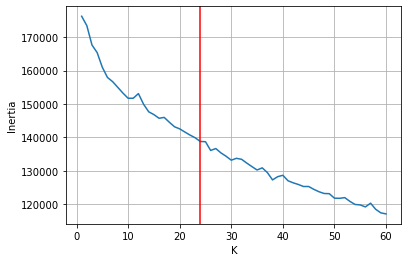

In [100]:
plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.axvline(24, c='r')
plt.grid(True)
plt.show()

#### Clustering reviews

In [112]:
np.random.seed(23)
cluster_model = KMeans(n_clusters=25)
clusters = cluster_model.fit_predict(shrunk_norm_matrix)
df_cl = pd.DataFrame({'Index': range(clusters.size), 'Cluster': clusters})

In [113]:
df_cl.head()

,Index,Cluster
0,0,12
1,1,9
2,2,19
3,3,1
4,4,21


In [114]:
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196777 entries, 0 to 196776
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   Index    196777 non-null  int64
 1   Cluster  196777 non-null  int32
dtypes: int32(1), int64(1)
memory usage: 2.3 MB


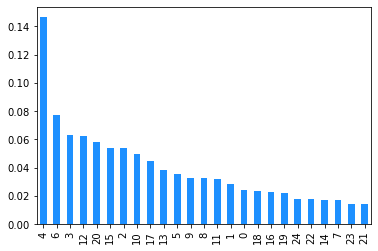

In [115]:
df_cl['Cluster'].value_counts(normalize=True).plot.bar(color='dodgerblue');

#### Checking reviews from a single cluster

In [116]:
df_cl5 = df_cl[df_cl['Cluster'] == 5]

In [117]:
df_cl5.sample(5)

,Index,Cluster
146011,146011,5
32522,32522,5
23703,23703,5
97928,97928,5
173016,173016,5


Let's print a few posts from cluster 5.

In [118]:
df_clean['Text'].iloc[146011]

"Best Decaf available in T-disc so far.  I'm hoping Starbucks will come out with a version soon... but meanwhile this one is not too bad at all."

In [119]:
df_clean['Text'].iloc[32522]

"this is the best cocoa i've had. way better than anything you can find at the supermarket, and even better than the other highly rated cocoas i tried from amazon.. also dissolves in water really easily and makes amazing hot chocolate (you can find recipes online - once you start making it from scratch you'll never buy the pre-mixed stuff again)."

In [120]:
df_clean['Text'].iloc[23703]

"DON'T BUY A JAR. BUY A CASE SO YOU WILL NEVER BE OUT. SIMPLY THE BEST I HAVE EVER TRIED."

In [122]:
df_clean['Text'].iloc[173016]

"Tim Horton's is among the best decaffeinated brands I've ever tasted.  I'm very happy that it's available here on Amazon and is prime eligible at a very good price."